## Xマッチのブキ多様度指数を求める

In [1]:
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import seaborn as sns
from packages.japanize import japanize
import packages.db as db
from packages.i18n import Locale, Translator
import packages.image as image
import packages.definitions as d
import packages.utils as u
import packages.visualize as v

locale = Locale.JA
lobby = d.Lobby.XMATCH
date_from = dt.date(2022, 12, 1)
date_to = dt.date(2023, 6, 8)
battles = db.load_battles(lobby=lobby, date_from=date_from, date_to=date_to)

試合数が 500 未満の日付のデータを削除する

In [2]:
daily_count = battles["date"].value_counts().to_frame("count")
invalid_dates = daily_count[(daily_count["count"] < 500) & (daily_count.index > dt.date(2022, 12, 10))].index
battles = battles[~battles["date"].isin(invalid_dates)]
invalid_dates

Index([2023-06-01, 2023-05-24, 2023-01-07, 2023-02-11, 2023-05-06, 2023-04-01], dtype='object')

バトル数: 225812


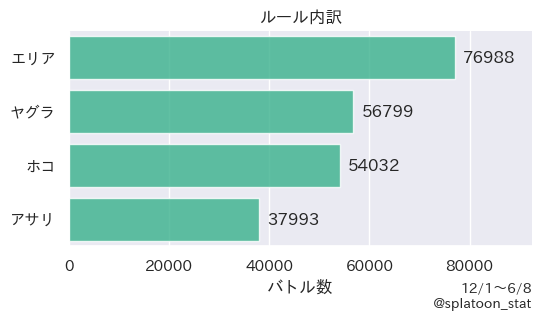

パワー不明バトル数: 13772


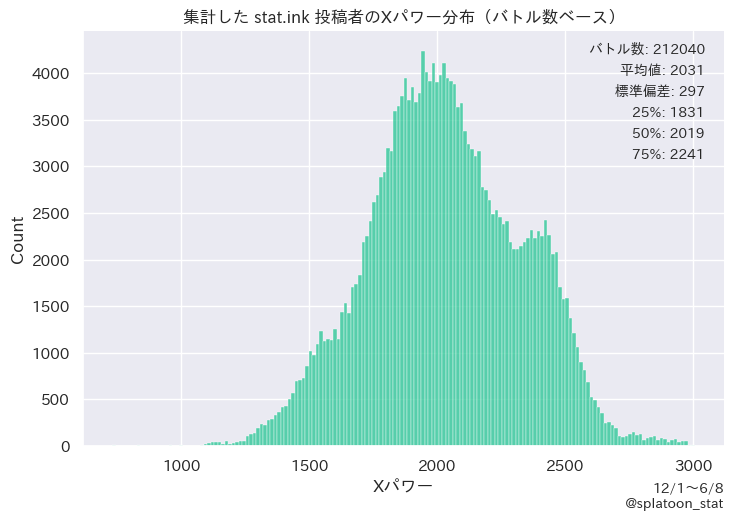

In [3]:
v.xmatch_mode_breakdown(battles=battles, locale=locale)
v.xmatch_power_distribution(battles=battles, locale=locale)

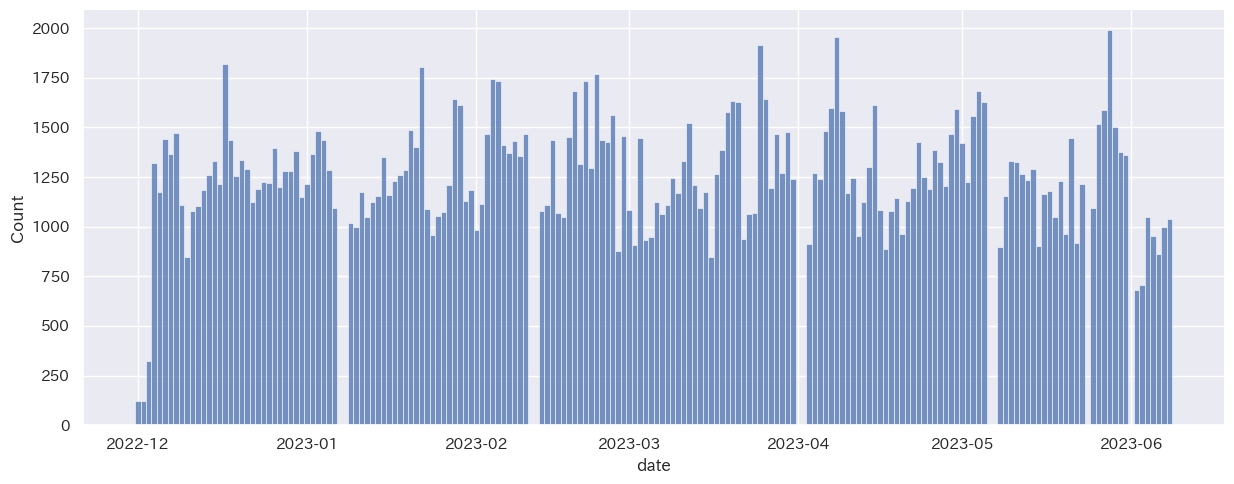

In [4]:
sns.set_theme()
japanize()

sns.displot(
    data=battles,
    x="date",
    aspect=2.5,
)
plt.show()

In [5]:
players = u.to_players(battles)

In [6]:
# 日付・ルールごとのブキ使用率
weapon_usage = players.groupby(["date", "mode"])["weapon"].value_counts(normalize=True).to_frame("usage")
# ルールごとのブキ使用率を平均する
weapon_usage = weapon_usage.reset_index().pivot(index=["date", "weapon"], columns="mode", values="usage").fillna(0).mean(axis=1).to_frame("usage")
weapon_usage

usage
date       weapon                      
2022-12-01 52gal               0.049809
           96gal               0.000687
           bamboo14mk1         0.009950
           barrelspinner       0.022814
           bold                0.008901
...                                 ...
2023-06-08 tristringer         0.012839
           variableroller      0.018555
           wakaba              0.041687
           wideroller          0.000345
           wideroller_collabo  0.003352

[13244 rows x 1 columns]

In [7]:
def calc_shannon(df: pd.DataFrame) -> float:
    P = df["usage"]
    return - sum(P * np.log2(P))

shannon = weapon_usage.groupby("date").apply(calc_shannon).to_frame("shannon")
shannon

,shannon
date,
2022-12-01,5.265040
2022-12-02,5.124929
2022-12-03,5.269137
2022-12-04,5.310924
2022-12-05,5.294940
...,...
2023-06-04,5.883260
2023-06-05,5.923611
2023-06-06,5.868519


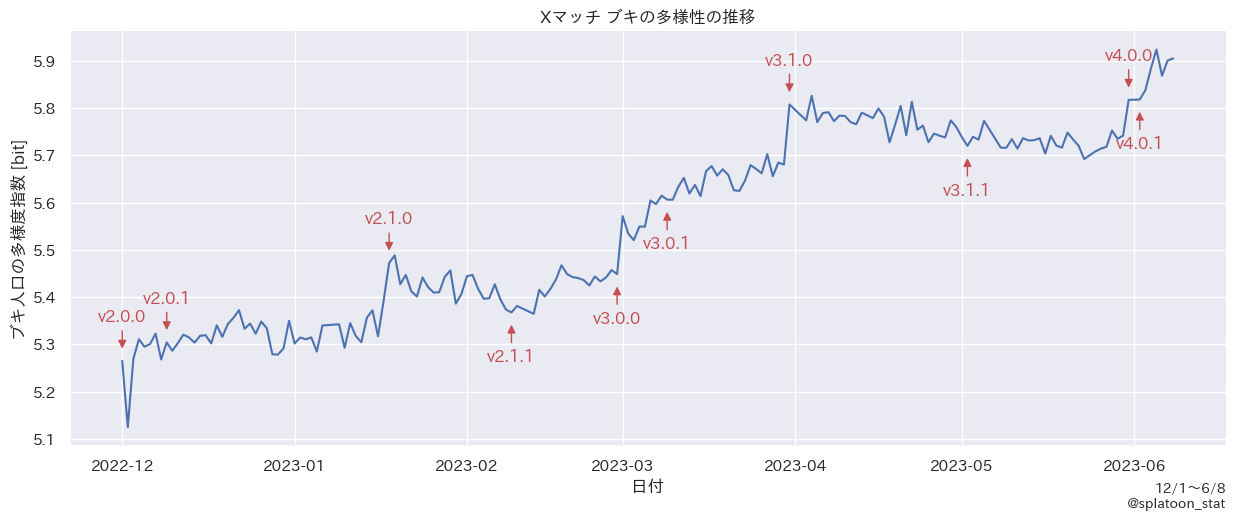

: 

In [10]:
import matplotlib.dates as mdates

sns.set_theme()
japanize()

locale = Locale.JA

i18n = Translator(locale)
i18n.add("title", "${lobby} ブキの多様性の推移", "Trends in Weapon Diversity in ${lobby}")
i18n.add("date", "日付", "Date")
i18n.add("ylabel", "ブキ人口の多様度指数 [bit]", "Shannon Index of Weapons [bit]")

g = sns.relplot(
    data=shannon,
    x="date",
    y="shannon",
    kind="line",
    aspect=2.5,
)
ax = g.ax

ax.set(
    title=i18n.t("title", lobby=i18n.t(lobby.value)),
    xlabel=i18n.t("date"),
    ylabel=i18n.t("ylabel"),
)
if locale == Locale.EN:
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%b. %-d"))

version_list = [
    (dt.date(2022, 12, 1), "v2.0.0", 1),
    (dt.date(2022, 12, 9), "v2.0.1", 1),
    (dt.date(2023, 1, 18), "v2.1.0", 1),
    (dt.date(2023, 2, 9), "v2.1.1", -1),
    (dt.date(2023, 2, 28), "v3.0.0", -1),
    (dt.date(2023, 3, 9), "v3.0.1", -1),
    (dt.date(2023, 3, 31), "v3.1.0", 1),
    (dt.date(2023, 5, 2), "v3.1.1", -1),
    (dt.date(2023, 5, 31), "v4.0.0", 1),
    (dt.date(2023, 6, 2), "v4.0.1", -1),
]
for (date, version, mul) in version_list:
    version_row = shannon.loc[date]
    ax.annotate(
        version,
        (mdates.date2num(version_row.name), version_row["shannon"] + 0.02 * mul),
        xytext=(0, 25 * mul),
        textcoords='offset points',
        arrowprops=dict(arrowstyle="-|>", color="r"),
        color="r",
        horizontalalignment='center',
        verticalalignment='center',
    )

u.credit(ax, g.fig, i18n.t_data_duration(battles, locale))
plt.show()